# Task 7: Stock Market Prediction using Numerical and Textual Analysis

## Step 1: Import required Libraries

In [66]:
import warnings
warnings.filterwarnings('ignore')

import math
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing, metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Dense, Activation

import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to C:\Users\ANTRA
[nltk_data]     RAJPUROHIT\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Step 2: Loading the Datasets

In [67]:
df1 = pd.read_csv('C:\\Users\\ANTRA RAJPUROHIT\\OneDrive\\Documents\\VS Code\\The Grip TSF\\The-Sparks-Foundation-Tasks\\data\\task7_BSESN.csv')
df2 = pd.read_csv('C:\\Users\\ANTRA RAJPUROHIT\\OneDrive\\Documents\\VS Code\\The Grip TSF\\The-Sparks-Foundation-Tasks\\data\\task7_india-news-headlines.csv')

In [68]:
df1.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,17-12-19,41052.35938,41401.64844,41005.17969,41352.17188,41352.17188,19000.0
1,18-12-19,41442.75000,41614.76953,41358.46875,41558.57031,41558.57031,24300.0
2,19-12-19,41571.82031,41719.28906,41456.39844,41673.92188,41673.92188,33300.0
3,20-12-19,41746.19922,41809.96094,41636.10938,41681.53906,41681.53906,33600.0
4,23-12-19,41548.26172,41701.62109,41474.60938,41642.66016,41642.66016,6200.0


In [69]:
df2.head(5)

,publish_date,headline_category,headline_text
0,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
1,20010102,unknown,Fissures in Hurriyat over Pak visit
2,20010102,unknown,America's unwanted heading for India?
3,20010102,unknown,For bigwigs; it is destination Goa
4,20010102,unknown,Extra buses to clear tourist traffic


## Step 3: Data Preprocessing

### 1. For df1

In [70]:
df1.dropna(axis=0, inplace=True)

In [71]:
df1 = df1.drop_duplicates()

Null values and duplicate entries are removed from the historical stock prices dataset 'df1'.

In [72]:
df1['Date'] = pd.to_datetime(df1['Date']).dt.normalize()

Converting the datatype of column 'Date' from type object to type 'datatime'

In [73]:
df1 = df1.filter(['Date', 'Close', 'Open', 'High', 'Low', 'Volume'])

Filtering the important columns

In [74]:
df1.set_index('Date', inplace=True)

Setting column 'Date' as the index column

In [75]:
df1 = df1.sort_index(ascending=True, axis=0)

Sorting the data according to Date

### 2. For df2

In [76]:
df2 = df2.drop_duplicates()

Dropping duplicates

In [77]:
df2['publish_date'] = df2['publish_date'].astype(str)
df2['publish_date'] = df2['publish_date'].apply(lambda x: x[0:4]+'-'+x[4:6]+'-'+x[6:8])
df2['publish_date'] = pd.to_datetime(df2['publish_date']).dt.normalize()

Converting the datatype of column 'Date' from type string to type 'datetime'

In [78]:
df2 = df2.filter(['publish_date', 'headline_text'])

Filtering the important columns

In [79]:
df2 = df2.groupby(['publish_date'])['headline_text'].apply(lambda x: ','.join(x)).reset_index()

Grouping the news headlines according to Date

In [80]:
df2.set_index('publish_date', inplace=True)

Setting Date as the index column

In [81]:
df2 = df2.sort_index(ascending=True, axis=0)

Sorting the data according to the Date

### 4. Concatenation of the Datasets df1 and df2

In [82]:
stock_data = pd.concat([df1, df2], axis=1)

stock_data.dropna(axis=0, inplace=True)

## Step 4: Sentiment Analysis

In [83]:
stock_data['compound'] = ''
stock_data['negative'] = ''
stock_data['neutral'] = ''
stock_data['positive'] = ''

In [84]:
sid = SentimentIntensityAnalyzer()
print('Start calculating sentiment scores:')

stock_data['compound'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['compound'])
print('Compound Done')
stock_data['negative'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['neg'])
print('Negative Done')
stock_data['neutral'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['neu'])
print('Neutral Done')
stock_data['positive'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['pos'])
print('Positive Done')
print('Stop')

Start calculating sentiment scores:
Compound Done
Negative Done
Neutral Done
Positive Done
Stop


Sentiment analysis is performed on the news headlines using the VADER (Valence Aware Dictionary and Sentiment Reasoner) sentiment intensity analyzer. The sentiment scores (compound, negative, neutral, positive) are calculated and added as additional columns to stock_data.

## Step 5: Data Preparation

In [85]:
stock_data.drop(['headline_text'], inplace=True, axis=1)
stock_data = stock_data[['Close', 'compound', 'negative', 'neutral', 'positive', 'Open', 'High', 'Low', 'Volume']]

Dropping unwanted 'headline_text' and rearranging columns

In [86]:
percentage_of_data = 1.0
data_to_use = int(percentage_of_data * (len(stock_data)-1))
train_end = int(data_to_use * 0.8)
total_data = len(stock_data)
start = total_data - data_to_use

Preparing the data for training and testing

In [87]:
close_price = stock_data.iloc[start:total_data, 0] # close
compound = stock_data.iloc[start:total_data, 1] # compound
negative = stock_data.iloc[start:total_data, 2] # neg
neutral = stock_data.iloc[start:total_data, 3] # neu
positive = stock_data.iloc[start:total_data, 4] # pos
open_price = stock_data.iloc[start:total_data, 5] # open
high = stock_data.iloc[start:total_data, 6] # high
low = stock_data.iloc[start:total_data, 7] # low
volume = stock_data.iloc[start:total_data, 8] # volume

In [88]:
# shifting next day close
close_price_shifted = close_price.shift(-1) 
compound_shifted = compound.shift(-1)

# concatenating the captured training data into a dataframe
data = pd.concat([close_price, close_price_shifted, compound, compound_shifted, volume, open_price, high, low], axis=1)

# setting column names of the revised stock data
data.columns = ['close_price', 'close_price_shifted', 'compound', 'compound_shifted', 'volume', 'open_price', 'high', 'low']

# dropping nulls
data = data.dropna()

In [89]:
# close price shifted set as the target variable
y = data['close_price_shifted']

In [90]:
# setting the features dataset for prediction  
cols = ['close_price', 'compound', 'compound_shifted', 'volume', 'open_price', 'high', 'low']
x = data[cols]

In [91]:
# scaling the feature dataset
scaler_x = preprocessing.MinMaxScaler(feature_range=(-1, 1))
x = np.array(x).reshape((len(x), len(cols)))
x = scaler_x.fit_transform(x)

# scaling the target variable
scaler_y = preprocessing.MinMaxScaler(feature_range=(-1, 1))
y = np.array(y).reshape((len(y), 1))
y = scaler_y.fit_transform(y)

x, y

(array([[ 0.50613139, -0.99989991, -0.99969973, ...,  0.48882267,
          0.470931  ,  0.51416868],
        [ 0.51728443, -0.99969973, -0.99989991, ...,  0.50168244,
          0.48179463,  0.52360164],
        [ 0.51802091, -0.99989991, -0.99969973, ...,  0.51905648,
          0.49121895,  0.54091208],
        ...,
        [ 0.96006811, -0.99929937, -0.99979982, ...,  0.97124474,
          0.9655309 ,  0.95658995],
        [ 0.96100703, -0.99979982, -0.99939946, ...,  0.97151289,
          0.96313625,  0.94600787],
        [ 1.        , -0.99939946, -0.99969973, ...,  1.        ,
          1.        ,  1.        ]]),
 array([[ 0.50103849],
        [ 0.50176709],
        [ 0.49804824],
        [ 0.48069709],
        [ 0.45224058],
        [ 0.49158985],
        [ 0.48995031],
        [ 0.46084703],
        [-0.7815238 ],
        [-0.29960836],
        [-0.09769343],
        [ 0.23578354],
        [ 0.21629442],
        [ 0.7862272 ],
        [ 0.51880774],
        [ 0.52769741],
     

## Step 6: Splitting Train and Test Datasets

In [92]:
# preparing training and test dataset
X_train = x[0:train_end, ]
X_test = x[train_end+1:len(x), ]    
y_train = y[0:train_end] 
y_test = y[train_end+1:len(y)]

In [93]:
# printing the shape of the training and the test datasets
print('Number of rows and columns in Training set X:', X_train.shape, 'and y:', y_train.shape)
print('Number of rows and columns in Test set X:', X_test.shape, 'and y:', y_test.shape)

Number of rows and columns in Training set X: (199, 7) and y: (199, 1)
Number of rows and columns in Test set X: (48, 7) and y: (48, 1)


## Step 7: Model Training and Evaluation

### Three regression models, Support Vector Regression (SVR), Gradient Boosting Regression (GBR), and Random Forest Regression, are trained on the training dataset ('X_train', 'y_train').

In [94]:
# Support Vector Regression (SVR)
svr_model = SVR()
svr_model.fit(X_train, y_train)
svr_train_predict = svr_model.predict(X_train)
svr_test_predict = svr_model.predict(X_test)

In [95]:
# Gradient Boosting Regression (GBR)
gbr_model = GradientBoostingRegressor()
gbr_model.fit(X_train, y_train)
gbr_train_predict = gbr_model.predict(X_train)
gbr_test_predict = gbr_model.predict(X_test)

In [96]:
# Random Forest Regression
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)
rf_train_predict = rf_model.predict(X_train)
rf_test_predict = rf_model.predict(X_test)

### A Long Short-Term Memory (LSTM) model is constructed using the Keras library and trained on the training dataset.

In [97]:
# seed set to achieve consistent and less random predictions
np.random.seed(2016)

# setting the architecture for the data model
model = Sequential()
model.add(LSTM(100, return_sequences=True, activation='tanh', input_shape=(len(cols), 1)))
model.add(Dropout(0.1))
model.add(LSTM(100, return_sequences=True, activation='tanh'))
model.add(Dropout(0.1))
model.add(LSTM(100, activation='tanh'))
model.add(Dropout(0.1))
model.add(Dense(1))

# printing the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 7, 100)            40800     
                                                                 
 dropout_3 (Dropout)         (None, 7, 100)            0         
                                                                 
 lstm_4 (LSTM)               (None, 7, 100)            80400     
                                                                 
 dropout_4 (Dropout)         (None, 7, 100)            0         
                                                                 
 lstm_5 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_5 (Dropout)         (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                

In [98]:
model.compile(loss='mean_squared_error', optimizer='adam') 

In [99]:
model.fit(X_train, y_train, epochs=100, batch_size=16, verbose=1)

Epoch 1/100
13/13 [==============================] - 5s 11ms/step - loss: 0.1725
Epoch 2/100
13/13 [==============================] - 0s 10ms/step - loss: 0.1489
Epoch 3/100
13/13 [==============================] - 0s 11ms/step - loss: 0.1219
Epoch 4/100
13/13 [==============================] - 0s 11ms/step - loss: 0.1017
Epoch 5/100
13/13 [==============================] - 0s 10ms/step - loss: 0.0989
Epoch 6/100
13/13 [==============================] - 0s 11ms/step - loss: 0.0971
Epoch 7/100
13/13 [==============================] - 0s 11ms/step - loss: 0.0970
Epoch 8/100
13/13 [==============================] - 0s 10ms/step - loss: 0.0955
Epoch 9/100
13/13 [==============================] - 0s 10ms/step - loss: 0.0953
Epoch 10/100
13/13 [==============================] - 0s 10ms/step - loss: 0.1034
Epoch 11/100
13/13 [==============================] - 0s 10ms/step - loss: 0.1024
Epoch 12/100
13/13 [==============================] - 0s 10ms/step - loss: 0.0990
Epoch 13/100
13/13 [=====

The trained models are used to make predictions on both the training and test datasets.

In [100]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

2/2 [==============================] - 0s 4ms/step


The predictions are transformed back to their original scale using inverse scaling.

In [101]:
# transforming back to original form
train_predict = scaler_y.inverse_transform(train_predict)
y_train = scaler_y.inverse_transform(y_train)
test_predict = scaler_y.inverse_transform(test_predict)
y_test = scaler_y.inverse_transform(y_test)

In [102]:
print('Evaluation using RMSE:')
print('RMSE for training dataset:', math.sqrt(metrics.mean_squared_error(y_train[:, 0], train_predict[:, 0])))
print('RMSE for testing dataset:', math.sqrt(metrics.mean_squared_error(y_test[:, 0], test_predict[:, 0])))

Evaluation using RMSE:
RMSE for training dataset: 2901.3500375795616
RMSE for testing dataset: 5954.24667796085


The model's performance is evaluated using RMSE (Root Mean Square Error). For the training dataset, the RMSE is 2901.35, indicating the average prediction error between the predicted and actual stock prices. The RMSE for the testing dataset is 5954.25, suggesting a slightly higher prediction error compared to the training dataset.

In [103]:
train_predict_plot = np.empty_like(x)
train_predict_plot[:, :] = np.nan
train_predict_plot[0:len(train_predict), :] = train_predict

test_predict_plot = np.empty_like(x)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict):len(x)-1, :] = test_predict

Shifting the predictions for plotting

## Step 8: Results Visualization

### Line plots are created to visualize the actual close prices, predicted close prices, and boundaries for the training and testing datasets.

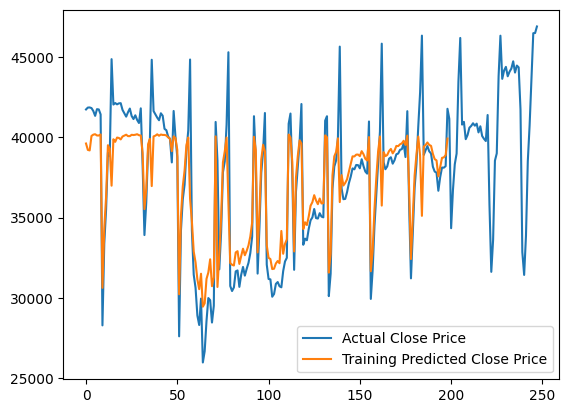

In [104]:
# plot the actual price, predicted price, and the boundary for the training dataset
plt.plot(scaler_y.inverse_transform(x[:, 0].reshape(-1, 1)), label='Actual Close Price')
plt.plot(train_predict_plot[:, 0], label='Training Predicted Close Price')
plt.legend()
plt.show()

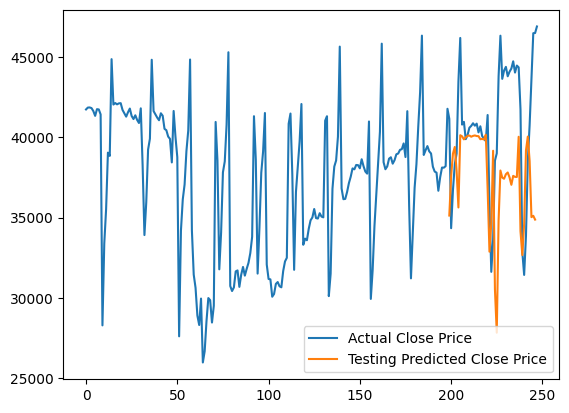

In [105]:
# plot the actual price, predicted price, and the boundary for the testing dataset
plt.plot(scaler_y.inverse_transform(x[:, 0].reshape(-1, 1)), label='Actual Close Price')
plt.plot(test_predict_plot[:, 0], label='Testing Predicted Close Price')
plt.legend()
plt.show()

### Another set of line plots is created to compare the actual close prices, predicted close prices (LSTM), and boundaries for the training and testing datasets across multiple models (SVR, GBR, Random Forest).

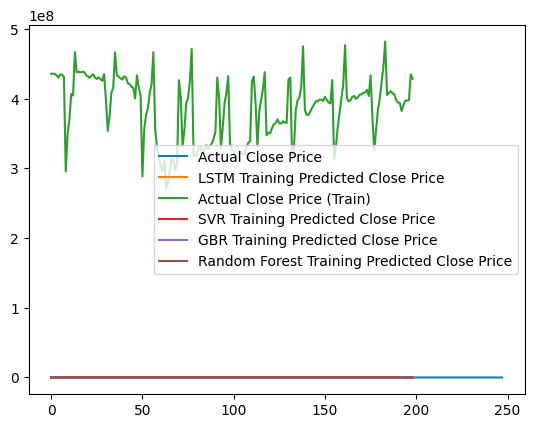

In [106]:
# plot the actual price, predicted price, and the boundary for the training dataset
plt.plot(scaler_y.inverse_transform(x[:, 0].reshape(-1, 1)), label='Actual Close Price')
plt.plot(train_predict_plot[:, 0], label='LSTM Training Predicted Close Price')
plt.plot(scaler_y.inverse_transform(y_train), label='Actual Close Price (Train)')
plt.plot(scaler_y.inverse_transform(svr_train_predict.reshape(-1, 1)), label='SVR Training Predicted Close Price')
plt.plot(scaler_y.inverse_transform(gbr_train_predict.reshape(-1, 1)), label='GBR Training Predicted Close Price')
plt.plot(scaler_y.inverse_transform(rf_train_predict.reshape(-1, 1)), label='Random Forest Training Predicted Close Price')
plt.legend()
plt.show()

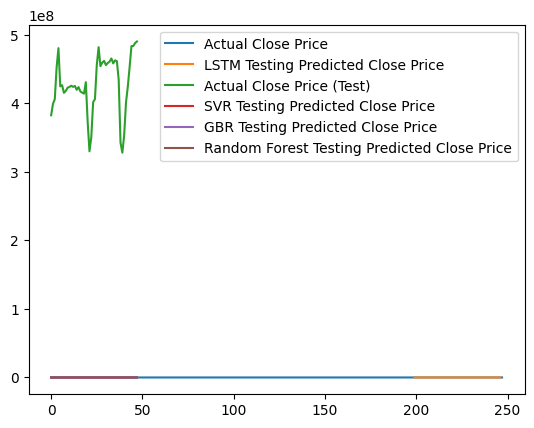

In [107]:
# plot the actual price, predicted price, and the boundary for the testing dataset
plt.plot(scaler_y.inverse_transform(x[:, 0].reshape(-1, 1)), label='Actual Close Price')
plt.plot(test_predict_plot[:, 0], label='LSTM Testing Predicted Close Price')
plt.plot(scaler_y.inverse_transform(y_test), label='Actual Close Price (Test)')
plt.plot(scaler_y.inverse_transform(svr_test_predict.reshape(-1, 1)), label='SVR Testing Predicted Close Price')
plt.plot(scaler_y.inverse_transform(gbr_test_predict.reshape(-1, 1)), label='GBR Testing Predicted Close Price')
plt.plot(scaler_y.inverse_transform(rf_test_predict.reshape(-1, 1)), label='Random Forest Testing Predicted Close Price')
plt.legend()
plt.show()

## Conclusion: This code implements a hybrid model for stock market prediction using numerical and textual analysis. It combines historical stock prices with sentiment scores from news headlines to predict future stock prices. The models (SVR, GBR, Random Forest, LSTM) are evaluated using RMSE, and the predicted prices are compared to actual close prices to assess their accuracy.